array([<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>], dtype=object)

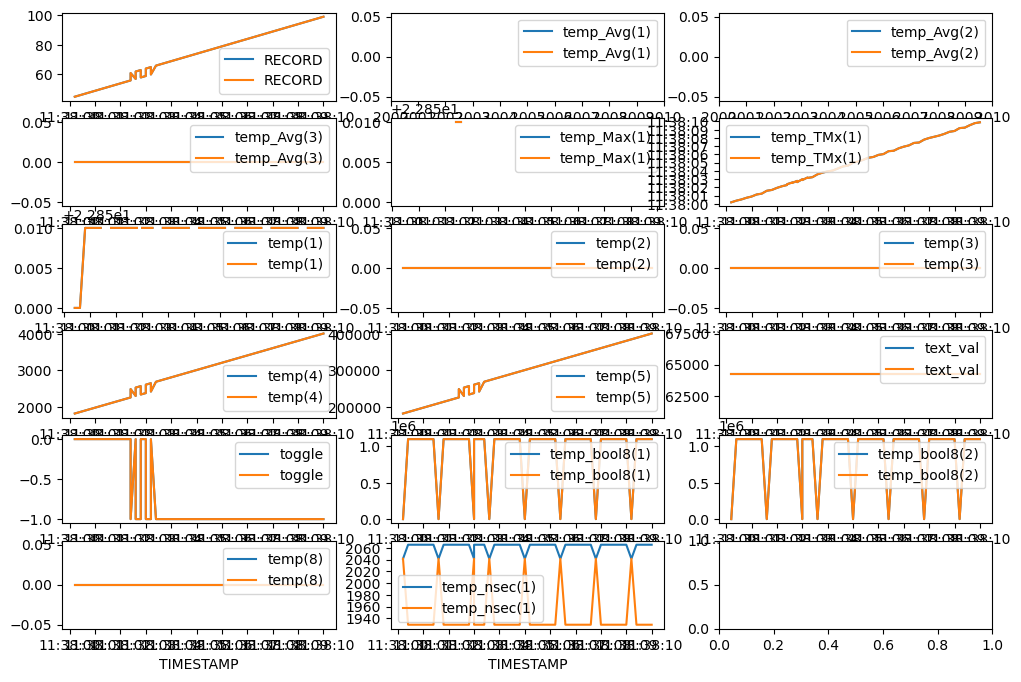

In [2]:
from math import ceil
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from camp2ascii import camp2ascii

in_dir = Path("tests/raw")

out_dir = Path("tests/c2a-basic")
out_dir.mkdir(parents=True, exist_ok=True)
for f in out_dir.iterdir():
    f.unlink() if f.is_file() else None
out_files = camp2ascii(str(in_dir / "*TOB1*"), out_dir)

file_to_plot = out_files[0]
my_tob3 = pd.read_csv(out_files[0], skiprows=[0, 2, 3], parse_dates=["TIMESTAMP"], index_col="TIMESTAMP", na_values="NAN")
my_tob3["temp_TMx(1)"] = pd.to_datetime(my_tob3["temp_TMx(1)"])
my_tob3["temp_nsec(1)"] = pd.to_datetime(my_tob3["temp_nsec(1)"])

ref_tob3 = pd.read_csv(Path(str(out_files[0]).replace("c2a", "cc")), skiprows=[0, 2, 3], na_values="NAN")
ref_tob3["TIMESTAMP"] = pd.to_datetime(ref_tob3["TIMESTAMP"], format="ISO8601")
ref_tob3.set_index("TIMESTAMP", inplace=True)
ref_tob3.sort_index(inplace=True)
ref_tob3["temp_TMx(1)"] = pd.to_datetime(ref_tob3["temp_TMx(1)"], format="ISO8601")
ref_tob3["temp_nsec(1)"] = pd.to_datetime(ref_tob3["temp_nsec(1)"], format="ISO8601")

fig, axs = plt.subplots(ceil(my_tob3.shape[1]/3), 3, figsize=(12, 8))
axs = axs.flatten()[:my_tob3.shape[1]]
my_tob3.plot(subplots=True, ax=axs, color="C0")
ref_tob3.plot(subplots=True, ax=axs, color="C1")

In [ ]:
with open("/home/alextsfox/git-repos/camp2ascii/tests/raw/TOB1_full1.dat", "rb") as f:
    f.seek(-8, 2)
    secnano = f.read(8)
import numpy as np
seconds = (int.from_bytes(secnano, byteorder="little", signed=False)) & 0xFFFFFFFF + 631_152_000
nanoseconds = (int.from_bytes(secnano, byteorder="little", signed=False)) >> 32
pd.to_datetime(seconds*1_000_000_000 + nanoseconds, unit="ns")
# def decode_secnano(secnano: np.ndarray[np.int64]) -> np.ndarray[np.int64]:
#     """Parse a SECNANO timestamp into a Unix timestamp in nanoseconds."""
#     seconds = np.int64(secnano & 0xFFFFFFFF) + TO_EPOCH
#     nanoseconds = np.int64(secnano >> 32)
#     return seconds*1_000_000_000 + nanoseconds

Timestamp('1970-01-01 00:00:00.000022')

In [ ]:

out_dir = Path("tests/c2a-timedate-filenames")
out_dir.mkdir(parents=True, exist_ok=True)
for f in out_dir.iterdir():
    f.unlink() if f.is_file() else None
camp2ascii(in_dir, out_dir, timedate_filenames=2)

in_dir = Path("tests/raw-2")
out_dir = Path("tests/c2a-time-split-1")
out_dir.mkdir(parents=True, exist_ok=True)
for f in out_dir.iterdir():
    f.unlink() if f.is_file() else None
camp2ascii(in_dir, out_dir, time_interval="1m")

out_dir = Path("tests/c2a-time-split-2")
out_dir.mkdir(parents=True, exist_ok=True)
for f in out_dir.iterdir():
    f.unlink() if f.is_file() else None
camp2ascii(in_dir, out_dir, time_interval="3m", timedate_filenames=1, contiguous_timeseries=2)